<a href="https://colab.research.google.com/github/tnwls6865/cau_deep_learning/blob/main/Linear_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/

In [ ]:
! cd /content/drive/MyDrive/deep_learning_implementing/

### CIFAR-10 dataset   
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.   
There are 50000 training images and 10000 test images.

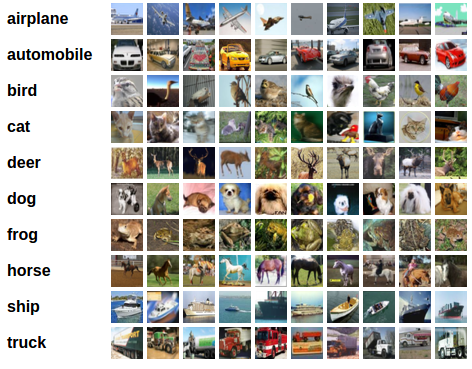

**Training a Nearest Neighbor Classifier**

### Nearest Neighbor Classifier.

새로운 데이터를 입력 받았을 때 학습 데이터에서 가장 가까이 있는 것이 무엇이냐를 중심으로 새로운 데이터의 label을 정해주는 알고리즘

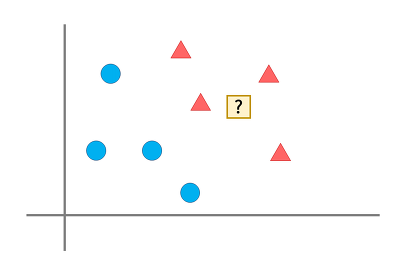

###k-Nearest Neighbor
학습 데이터에서 가장 가까운 단일 데이터를 보는 것 대신 가장 가까운 상위 K개의 데이터를 보고 새로운 데이터의 label을 설정해주는 알고리즘  
K는 hyperparameter  

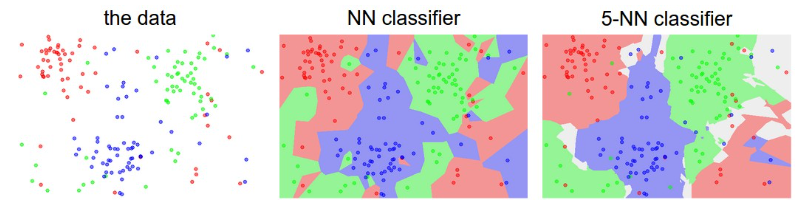   
The kNN classifier consists of two stages:

* During training, the classifier takes the training data and simply remembers it
* During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
* The value of k is cross-validated


**Loead and normalize CIFAR10**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms


CIFAR-10 데이터 셋 설정

In [ ]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 73577489.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

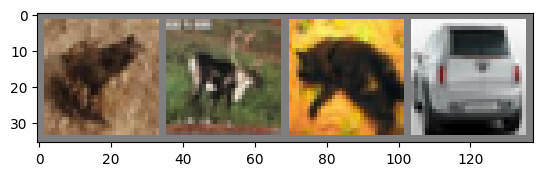

frog  deer  cat   car  


In [ ]:
# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 학습 데이터셋과 테스트 데이터셋을 각각 배열로 변환하기 위해 리스트 초기화
X_train, y_train = [], []
X_test, y_test = [], []

# 학습 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_train과 y_train에 저장
for i, (X, y) in enumerate(trainset):
    X_train.append(np.array(X))
    y_train.append(np.array(y))

In [ ]:
# 학습 데이터셋 크기 출력
print(len(X_train))
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

50000
(50000, 3, 32, 32)
(50000,)


In [ ]:
# 테스트 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_test와 y_test에 저장
for i, (X, y) in enumerate(testset):
    X_test.append(np.array(X))
    y_test.append(np.array(y))

print(len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

10000
(10000, 3, 32, 32)
(10000,)


In [ ]:
# 효율성을 위한 데이터 샘플링
num_training = 5000
mask = range(num_training)  # 5000개의 샘플을 선택할 마스크 생성
X_train_sub = X_train[mask] # 학습 데이터에서 일부 샘플링
y_train_sub = y_train[mask] # 학습 라벨에서 일부 샘플링

# 테스트 데이터 일부를 샘플링
num_test = 500
mask = range(num_test) # 500개의 샘플을 선택할 마스크 생성
X_test_sub = X_test[mask] # 테스트 데이터에서 일부 샘플링
y_test_sub = y_test[mask] # 테스트 라벨에서 일부 샘플링

In [ ]:
# 이미지 데이터를 행렬 형태로 변환 (이미지를 1차원 벡터로 변환)
X_train_sub = np.reshape(X_train_sub, (X_train_sub.shape[0], -1))
X_test_sub = np.reshape(X_test_sub, (X_test_sub.shape[0], -1))
print(X_train_sub.shape, X_test_sub.shape)

(5000, 3072) (500, 3072)


**Distance Metric**
### L2 Distance
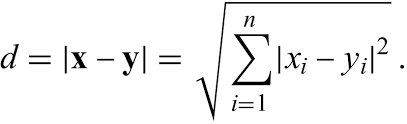

In [ ]:
class KNearestNeighbor(object):
    """ L2 거리를 사용하는 kNN 분류기 """
    def __init__(self):
         # 생성자 함수. 특별한 초기화 작업은 없어서 pass
        pass

    def train(self, X, y):
        # kNN에서 학습은 별도의 모델 학습을 하지 않고 단순히 학습 데이터를 저장
        ##############
        #### code ####
        ##############


    def predict(self, X, k=1):
        # 예측 함수, 주어진 데이터에 대해 가장 가까운 k개의 이웃을 찾아 예측

        # 두 개의 반복문을 사용해 L2 거리를 계산하는 함수 호출
        dists = self.compute_distances_two_loops(X)

        # 계산된 거리 행렬을 사용해 라벨 예측
        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        # 두 개의 반복문을 사용하여 테스트 데이터와 학습 데이터 사이의 L2 거리를 계산
        num_test = X.shape[0] # 테스트 데이터의 개수
        num_train = self.X_train.shape[0] # 학습 데이터의 개수

        # 거리 행렬 초기화, 각 테스트 데이터와 학습 데이터 사이의 거리를 저장할 배열
        dists = np.zeros((num_test, num_train))

         # 테스트 데이터와 학습 데이터의 거리를 계산하는 두 개의 반복문
        for i in range(num_test):
            for j in range(num_train):
                # L2 거리 계산 (유클리드 거리)
                ##############
                #### code ####
                ##############



        # 계산된 거리 행렬 반환
        return dists

    def predict_labels(self, dists, k=1):
        # 주어진 거리 행렬을 사용해 예측할 라벨을 결정
        num_test = dists.shape[0] # 테스트 데이터의 개수
        y_pred = np.zeros(num_test) # 예측 결과를 저장할 배열 초기화

        # 각 테스트 샘플에 대해 가장 가까운 k개의 학습 샘플을 찾고 라벨을 예측
        for i in range(num_test):
            closest_y = []
            # 거리 행렬에서 가장 가까운 k개의 이웃의 인덱스 가져오기
            k_nearest_idxs = np.argsort(dists[i, :])[:k]
            # 가장 가까운 k개의 이웃의 라벨을 저장
            closest_y = self.y_train[k_nearest_idxs].flatten()

            # 가장 빈도가 높은 라벨을 예측값으로 선택
            y_pred[i] = np.argmax(np.bincount(closest_y))

        return y_pred

In [ ]:
# kNN 분류기 인스턴스 생성
classifier = KNearestNeighbor()
# 학습 데이터로 분류기 훈련
classifier.train(X_train_sub, y_train_sub)

In [ ]:
# 테스트 데이터와 학습 데이터 사이의 거리 계산
dists = classifier.compute_distances_two_loops(X_test_sub)
print(dists.shape)

(500, 5000)


In [ ]:
# 거리 행렬을 사용하여 테스트 데이터에 대한 라벨 예측
y_test_pred = classifier.predict_labels(dists, k=1)

In [ ]:
num_correct = np.sum(y_test_pred == y_test_sub.flatten())
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy*100))

Got 137 / 500 correct => accuracy: 27.400000


### K 값에 따른 정확도 계산

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# k 값에 따른 정확도 비교 함수
def evaluate_knn_for_k_range(k_values, classifier, X_train, y_train, X_test, y_test):
    accuracies = []

    # k 값에 따라 정확도 계산
    for k in k_values:
        print(f'Evaluating k={k}...')
        classifier.train(X_train, y_train)  # 학습 데이터로 훈련
        dists = classifier.compute_distances_two_loops(X_test)  # 거리 계산
        y_test_pred = classifier.predict_labels(dists, k=k)  # 라벨 예측
        num_correct = np.sum(y_test_pred == y_test.flatten())  # 정확도 계산
        accuracy = float(num_correct) / X_test.shape[0]
        accuracies.append(accuracy)  # 정확도 저장
        print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')

    return accuracies

Evaluating k=1...
Accuracy for k=1: 27.40%
Evaluating k=3...
Accuracy for k=3: 27.20%
Evaluating k=5...
Accuracy for k=5: 27.80%
Evaluating k=7...
Accuracy for k=7: 27.40%
Evaluating k=9...
Accuracy for k=9: 26.80%
Evaluating k=11...
Accuracy for k=11: 26.20%
Evaluating k=13...
Accuracy for k=13: 26.60%
Evaluating k=15...
Accuracy for k=15: 27.20%


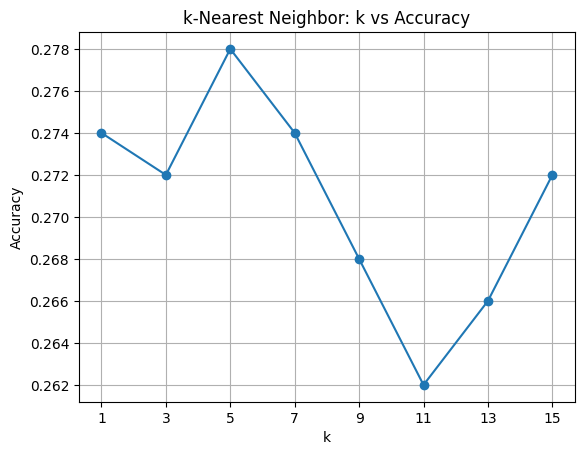

In [ ]:
# k 값 리스트 설정
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

# k에 따른 정확도 계산
accuracies = evaluate_knn_for_k_range(k_values, classifier, X_train_sub, y_train_sub, X_test_sub, y_test_sub)

# 정확도 시각화
plt.plot(k_values, accuracies, marker='o')
plt.title('k-Nearest Neighbor: k vs Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Linear Classifier
Linear Classification(선형 분류)란 쉽게 말해서 선을 이용하여 집단을 두개 이상으로 분류하는 모델  
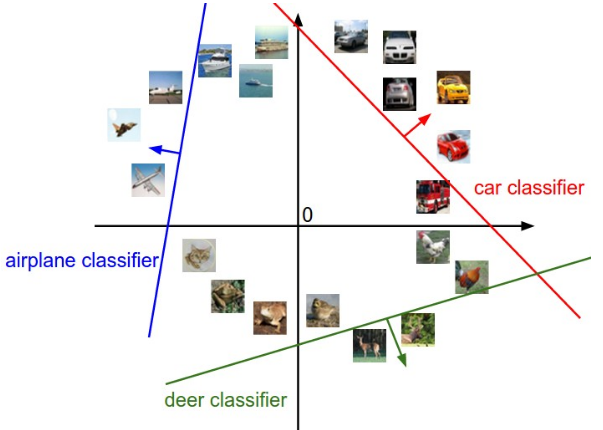

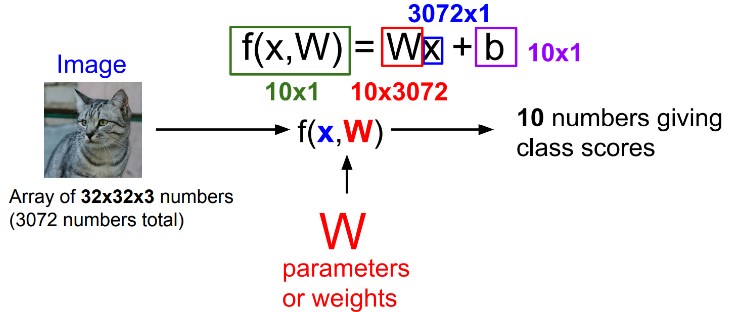

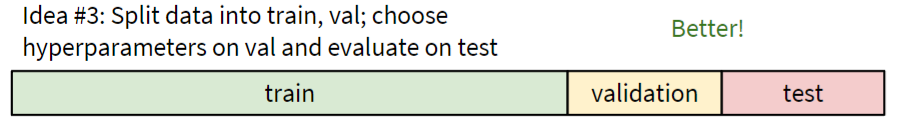

In [ ]:
# 데이터셋을 분할하여 학습, 검증, 테스트 세트로 나눔
num_training = 49000
num_validation = 1000
num_test = 1000

# 검증 데이터 분리
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
# 학습 데이터 분리
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
# 테스트 데이터 분리
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3074)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3074)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [ ]:
# 데이터 전처리: 이미지 데이터를 행(row) 형태로 변환
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3074)
Validation data shape:  (1000, 3074)
Test data shape:  (1000, 3072)


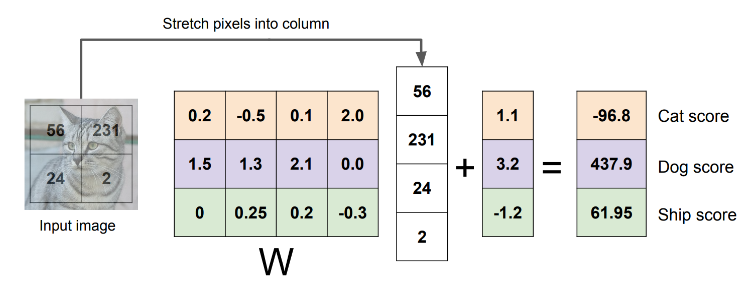

In [ ]:
# 데이터에 편향(bias) 추가 (모든 데이터에 1 추가)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(49000, 3075) (1000, 3075) (1000, 3073)


In [ ]:
# 선형 분류기 클래스 정의
class LinearClassifier(object):
    def __init__(self):
        self.W = None # 가중치 초기화

    def train(self, X, y, learning_rate=1e-3, num_iters=100,
                batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # 클래스의 수를 0 ~ K-1로 가정
        if self.W is None:
            # 가중치 초기화 (랜덤 값으로 초기화)
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # 배치 경사 하강법(Gradient Descent) 실행하여 W 최적화
        loss_history = []
        for it in range(num_iters):
            # 전체 데이터셋에 대해 손실과 그라디언트 계산
            loss, grad = self.loss(X, y)
            loss_history.append(loss)

            # 가중치 업데이트 (Gradient Descent)
            self.W -= learning_rate * grad

            # 손실 값 출력
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history


    def predict(self, X):
        # 주어진 데이터 X에 대해 예측 값 반환
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        return y_pred

    def loss(self, W, X_batch, y_batch):

        pass

**Multiclass Support Vector Machine(SVM) loss**

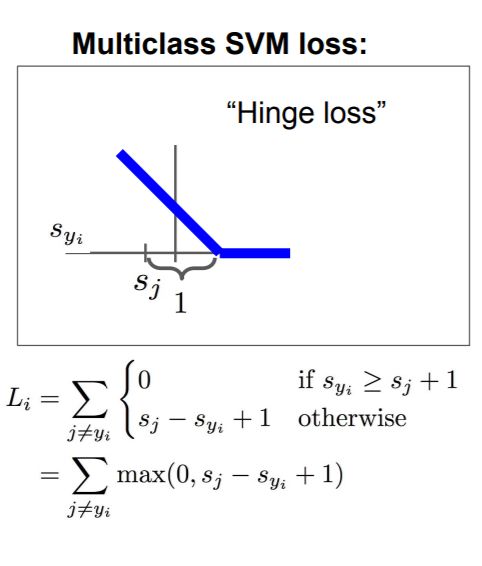

In [ ]:
# SVM 손실 함수 구현 (벡터화된 버전)
def svm_loss_vectorized(W, X, y):
    C = W.shape[1]
    N = X.shape[0]
    loss = 0.0
    dW = np.zeros(W.shape) # 그라디언트 초기화

    # 점수 계산 (X와 W의 행렬 곱)
    ##############
    #### code ####
    ##############

    # 올바른 클래스의 점수
    ##############
    #### code ####
    ##############

    # 손실 계산 (마진의 합)
    loss = np.sum(margins) / N

    # 그라디언트 계산
    dscores = np.zeros_like(scores)  # (N, C)
    dscores[margins > 0] = 1
    dscores[np.arange(N), y] -= np.sum(dscores, axis=1)   #  (N, 1) = (N, 1)

    dW = np.dot(X.T, dscores)
    dW /= N

    return loss, dW

In [ ]:
# SVM 분류기 클래스 정의
class LinearSVM(LinearClassifier):
    """ 다중 클래스 SVM 손실 함수를 사용하는 클래스 """
    def loss(self, X_batch, y_batch):
        return svm_loss_vectorized(self.W, X_batch, y_batch)

In [ ]:
# SVM 분류기 학습
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train.flatten(), learning_rate=1e-5, num_iters=300, verbose=True)

iteration 0 / 300: loss 9.011170
iteration 10 / 300: loss 8.958952
iteration 20 / 300: loss 8.906734
iteration 30 / 300: loss 8.854516
iteration 40 / 300: loss 8.802298
iteration 50 / 300: loss 8.750080
iteration 60 / 300: loss 8.697862
iteration 70 / 300: loss 8.645644
iteration 80 / 300: loss 8.593425
iteration 90 / 300: loss 8.541207
iteration 100 / 300: loss 8.488989
iteration 110 / 300: loss 8.436771
iteration 120 / 300: loss 8.384553
iteration 130 / 300: loss 8.332336
iteration 140 / 300: loss 8.280153
iteration 150 / 300: loss 8.228065
iteration 160 / 300: loss 8.176129
iteration 170 / 300: loss 8.124482
iteration 180 / 300: loss 8.073332
iteration 190 / 300: loss 8.022859
iteration 200 / 300: loss 7.973208
iteration 210 / 300: loss 7.924606
iteration 220 / 300: loss 7.877199
iteration 230 / 300: loss 7.831090
iteration 240 / 300: loss 7.786442
iteration 250 / 300: loss 7.743271
iteration 260 / 300: loss 7.701669
iteration 270 / 300: loss 7.661694
iteration 280 / 300: loss 7.623

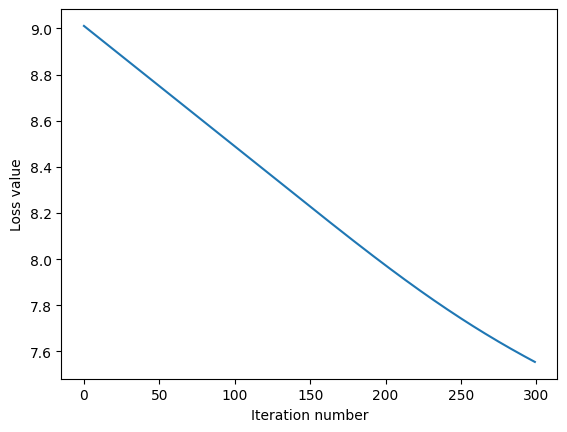

In [ ]:
# 손실 값 그래프 그리기
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# 학습 데이터에 대한 예측 정확도 계산
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

# 검증 데이터에 대한 예측 정확도 계산
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.248000
validation accuracy: 0.254000


### Cross-Validation (K-fold)
 scikit-learn 라이브러리의 KFold를 사용할 수 있음
 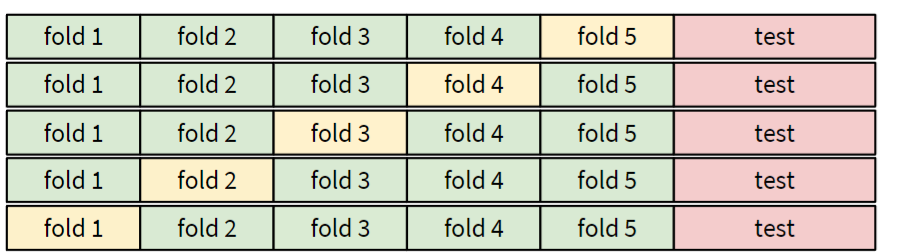

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [ ]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 학습 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_train과 y_train에 저장
X_train, y_train = [], []
for i, (X, y) in enumerate(trainset):
    X_train.append(np.array(X))
    y_train.append(np.array(y))

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)  # 데이터 크기 확인

# CIFAR-10 이미지를 벡터화 (1차원 배열로 변환)
X_train = np.reshape(X_train, (X_train.shape[0], -1))

# 편향 추가
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

print('Training data shape after reshaping: ', X_train.shape)

Files already downloaded and verified
(50000, 3, 32, 32) (50000,)
Training data shape after reshaping:  (50000, 3073)


In [ ]:
# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
X_test, y_test = [], []
for i, (X, y) in enumerate(testset):
  X_test.append(np.array(X))
  y_test.append(np.array(y))

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)  # 데이터 크기 확인

# CIFAR-10 이미지를 벡터화 (1차원 배열로 변환)
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# 편향 추가
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Training data shape after reshaping: ', X_test.shape)

Files already downloaded and verified
(10000, 3, 32, 32) (10000,)
Training data shape after reshaping:  (10000, 3073)


In [ ]:
# 선형 분류기 클래스 정의
class LinearClassifier(object):
    def __init__(self):
        self.W = None  # 가중치 초기화

    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # 클래스의 수를 0 ~ K-1로 가정
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)  # 가중치 초기화

        loss_history = []
        for it in range(num_iters):
            loss, grad = self.loss(X, y)  # 손실 및 그라디언트 계산
            loss_history.append(loss)
            self.W -= learning_rate * grad  # 가중치 업데이트

            if verbose and it % 10 == 0:
                print(f'Iteration {it}/{num_iters}: Loss {loss:.4f}')
        return loss_history

    def predict(self, X):
        return np.argmax(np.dot(X, self.W), axis=1)

    def loss(self, X_batch, y_batch):
        pass

# SVM 손실 함수 구현 (벡터화된 버전)
def svm_loss_vectorized(W, X, y):
    C = W.shape[1]
    N = X.shape[0]
    loss = 0.0
    dW = np.zeros(W.shape)  # 그라디언트 초기화

    scores = np.dot(X, W)  # 점수 계산
    correct_class_scores = scores[np.arange(N), y].reshape(-1, 1)

    margins = np.maximum(0, scores - correct_class_scores + 1)  # 마진 계산
    margins[np.arange(N), y] = 0  # 정답 클래스에 대한 마진을 0으로 설정

    loss = np.sum(margins) / N  # 손실 계산
    dscores = np.zeros_like(scores)
    dscores[margins > 0] = 1
    dscores[np.arange(N), y] -= np.sum(dscores, axis=1)

    dW = np.dot(X.T, dscores) / N  # 그라디언트 계산
    return loss, dW

# SVM 분류기 클래스 정의
class LinearSVM(LinearClassifier):
    def loss(self, X_batch, y_batch):
        return svm_loss_vectorized(self.W, X_batch, y_batch)

In [ ]:
# K-Fold 객체 생성 (5개의 폴드로 나누기)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def train_and_evaluate_svm_kfold(X_train, y_train, num_epochs=100):
    accuracies = []  # 각 폴드의 정확도를 저장할 리스트 초기화
    fold = 1  # 현재 폴드 번호 (1부터 시작)

    # KFold 객체의 split 메서드를 사용하여 데이터를 훈련 및 검증 세트로 나눔
    for train_index, val_index in kf.split(X_train):
        print(f'\nTraining fold {fold}...')  # 현재 폴드 번호 출력

        # 훈련 데이터와 검증 데이터를 폴드 인덱스에 따라 분할
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # 모델 학습
        svm = LinearSVM()  # Linear SVM 모델 초기화
        svm.train(X_train_fold, y_train_fold, learning_rate=1e-3, num_iters=num_epochs, verbose=True)  # SVM 모델 학습

        # 검증 데이터에 대한 예측 수행
        y_val_pred = svm.predict(X_val_fold)

        # 검증 데이터의 정확도 계산
        accuracy = np.mean(y_val_fold == y_val_pred)
        print(f'Validation accuracy for fold {fold}: {accuracy:.4f}')  # 현재 폴드의 검증 정확도 출력

        # 정확도를 리스트에 추가
        accuracies.append(accuracy)
        fold += 1  # 다음 폴드로 이동

    return accuracies  # 모든 폴드의 정확도를 반환

# K-Fold Cross Validation 수행
accuracies = train_and_evaluate_svm_kfold(X_train, y_train, num_epochs=100)

# 폴드별 평균 정확도 출력
print(f'\nMean accuracy across folds: {np.mean(accuracies):.4f}')



Training fold 1...
Iteration 0/100: Loss 9.0206
Iteration 10/100: Loss 6.4801
Iteration 20/100: Loss 5.9823
Iteration 30/100: Loss 5.7265
Iteration 40/100: Loss 5.5615
Iteration 50/100: Loss 5.4425
Iteration 60/100: Loss 5.3509
Iteration 70/100: Loss 5.2776
Iteration 80/100: Loss 5.2170
Iteration 90/100: Loss 5.1660
Validation accuracy for fold 1: 0.3519

Training fold 2...
Iteration 0/100: Loss 9.0081
Iteration 10/100: Loss 6.4747
Iteration 20/100: Loss 5.9789
Iteration 30/100: Loss 5.7234
Iteration 40/100: Loss 5.5583
Iteration 50/100: Loss 5.4395
Iteration 60/100: Loss 5.3482
Iteration 70/100: Loss 5.2752
Iteration 80/100: Loss 5.2148
Iteration 90/100: Loss 5.1639
Validation accuracy for fold 2: 0.3503

Training fold 3...
Iteration 0/100: Loss 8.9957
Iteration 10/100: Loss 6.4792
Iteration 20/100: Loss 5.9821
Iteration 30/100: Loss 5.7259
Iteration 40/100: Loss 5.5606
Iteration 50/100: Loss 5.4413
Iteration 60/100: Loss 5.3494
Iteration 70/100: Loss 5.2755
Iteration 80/100: Loss 5.

In [ ]:
# 최종 테스트 데이터로 SVM 모델 평가
svm = LinearSVM()
svm.train(X_train, y_train, learning_rate=1e-3, num_iters=100, verbose=True)


Iteration 0/100: Loss 8.9899
Iteration 10/100: Loss 6.4753
Iteration 20/100: Loss 5.9821
Iteration 30/100: Loss 5.7273
Iteration 40/100: Loss 5.5621
Iteration 50/100: Loss 5.4428
Iteration 60/100: Loss 5.3509
Iteration 70/100: Loss 5.2774
Iteration 80/100: Loss 5.2168
Iteration 90/100: Loss 5.1657


[8.989891098858855,
 8.467977210058194,
 7.951507930442094,
 7.514708675606427,
 7.229590212222872,
 7.033227413609209,
 6.881085367514096,
 6.755972373475455,
 6.649311374689041,
 6.556712329041806,
 6.475291263425029,
 6.403155296653209,
 6.338504269231128,
 6.280053955998175,
 6.226809685214415,
 6.178005254842828,
 6.133064446509973,
 6.091351309836358,
 6.052501452182261,
 6.0162111323179515,
 5.982129084136812,
 5.950110031230717,
 5.919916510254581,
 5.891363182965899,
 5.864334767274972,
 5.838667270668181,
 5.814254620136937,
 5.791019118496019,
 5.768828782779096,
 5.74759160049141,
 5.727254052253163,
 5.707766422941751,
 5.6890724069424765,
 5.671109176681275,
 5.653807166653348,
 5.637152097861888,
 5.621079506934882,
 5.605563714163433,
 5.59058866183075,
 5.57609342609114,
 5.562072593222059,
 5.548500160044294,
 5.53535447241175,
 5.522605442284725,
 5.51022603014286,
 5.498194530931066,
 5.486504932817349,
 5.475138381467628,
 5.46407439867997,
 5.453296799945469,
 5.4

In [ ]:
# 테스트 데이터로 예측 수행
y_test_pred = svm.predict(X_test)

In [ ]:
test_accuracy = np.mean(y_test == y_test_pred)
print(f'\nTest accuracy: {test_accuracy * 100:.2f}%')


Test accuracy: 35.38%


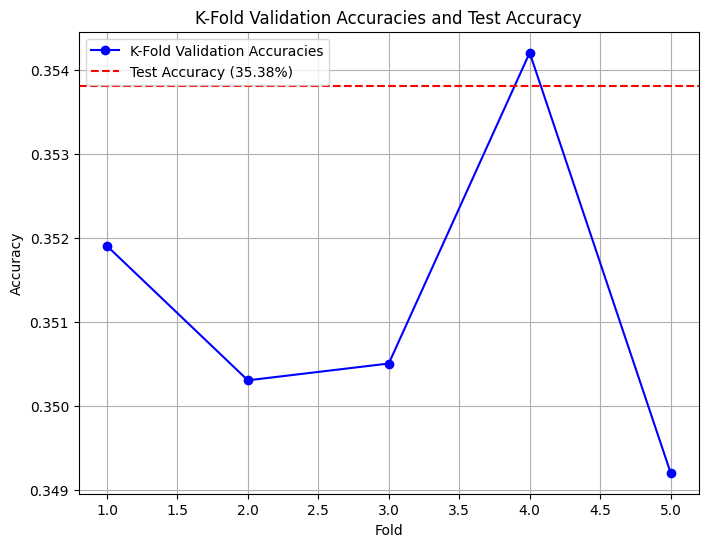

In [ ]:
# KFold 정확도 시각화에 최종 테스트 정확도 추가
def plot_kfold_accuracies(accuracies, test_accuracy):
    plt.figure(figsize=(8, 6))

    # K-Fold Validation Accuracies
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b', label='K-Fold Validation Accuracies')

    # Test Accuracy 추가
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy ({test_accuracy*100:.2f}%)')

    # 그래프 타이틀 및 라벨 설정
    plt.title('K-Fold Validation Accuracies and Test Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# K-Fold 정확도와 최종 테스트 정확도를 시각화
plot_kfold_accuracies(accuracies, test_accuracy)

In [ ]:
# Softmax 분류기 학습
softmax = Softmax()
loss_hist = softmax.train(X_train, y_train.flatten(), learning_rate=1e-5, num_iters=300, verbose=True)

iteration 0 / 300: loss 2.305862
iteration 10 / 300: loss 2.305325
iteration 20 / 300: loss 2.304791
iteration 30 / 300: loss 2.304257
iteration 40 / 300: loss 2.303726
iteration 50 / 300: loss 2.303196
iteration 60 / 300: loss 2.302667
iteration 70 / 300: loss 2.302140
iteration 80 / 300: loss 2.301615
iteration 90 / 300: loss 2.301091
iteration 100 / 300: loss 2.300569
iteration 110 / 300: loss 2.300048
iteration 120 / 300: loss 2.299528
iteration 130 / 300: loss 2.299011
iteration 140 / 300: loss 2.298495
iteration 150 / 300: loss 2.297980
iteration 160 / 300: loss 2.297467
iteration 170 / 300: loss 2.296955
iteration 180 / 300: loss 2.296445
iteration 190 / 300: loss 2.295936
iteration 200 / 300: loss 2.295429
iteration 210 / 300: loss 2.294923
iteration 220 / 300: loss 2.294419
iteration 230 / 300: loss 2.293916
iteration 240 / 300: loss 2.293415
iteration 250 / 300: loss 2.292915
iteration 260 / 300: loss 2.292416
iteration 270 / 300: loss 2.291920
iteration 280 / 300: loss 2.291

### Data Augmentation
Data Augmentation은 학습 데이터를 다양하게 변형하여 데이터의 다양성을 증가시켜 모델이 과적합되는 것을 방지하고, 더 일반화된 모델을 만드는 데 유용함

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 이미지 시각화 함수 정의
def imshow(img):
    img = img / 2 + 0.5  # 정규화를 해제하여 원래 값으로 변환
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 이미지 축을 조정하여 시각화
    plt.show()

In [ ]:
# CIFAR-10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [ ]:
# DataLoader에서 하나의 배치 가져오기 (iter()로 이터레이터 생성)
def get_single_image_loader(transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)
    return trainloader

In [ ]:
# 증강 기법 적용 후 시각화
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def visualize_augmentations(transform, title):
    loader = get_single_image_loader(transform)
    dataiter = iter(loader)  # 이터레이터 생성
    images, labels = next(dataiter)  # next() 함수를 사용하여 배치 가져오기

    print(f'Visualization for: {title}\n')
    print(f'Labels : {classes[labels[0]]}')
    imshow(torchvision.utils.make_grid(images))

Original Images:
Files already downloaded and verified
Visualization for: Original Images

Labels : cat


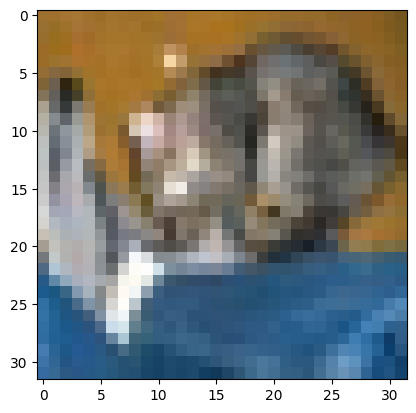

In [ ]:
# 원본 이미지 시각화
print("Original Images:")
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_original, "Original Images")


Random Horizontal Flip:
Files already downloaded and verified
Visualization for: Random Horizontal Flip

Labels : cat


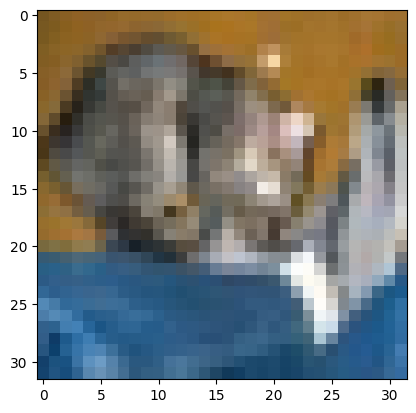

In [ ]:
# 1. Random Horizontal Flip
print("Random Horizontal Flip:")
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # 무조건 좌우 반전
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_flip, "Random Horizontal Flip")


Random Crop:
Files already downloaded and verified
Visualization for: Random Crop

Labels : cat


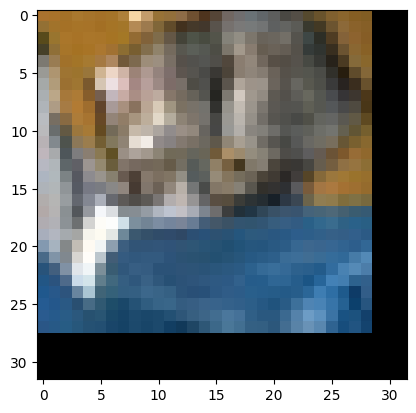

In [ ]:
# 2. Random Crop
print("Random Crop:")
transform_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 무작위로 자르기
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_crop, "Random Crop")

Random Rotation:
Files already downloaded and verified
Visualization for: Random Rotation

Labels : cat


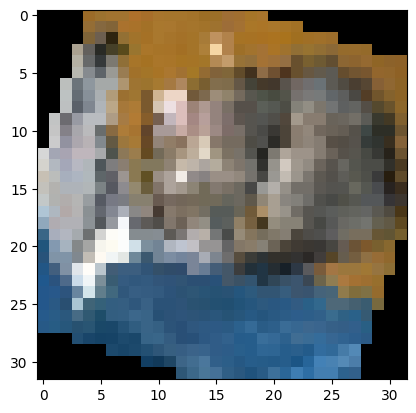

In [ ]:
# 3. Random Rotation
print("Random Rotation:")
transform_rotate = transforms.Compose([
    transforms.RandomRotation(30),  # 30도 이내에서 회전
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_rotate, "Random Rotation")

Color Jitter:
Files already downloaded and verified
Visualization for: Color Jitter

Labels : cat


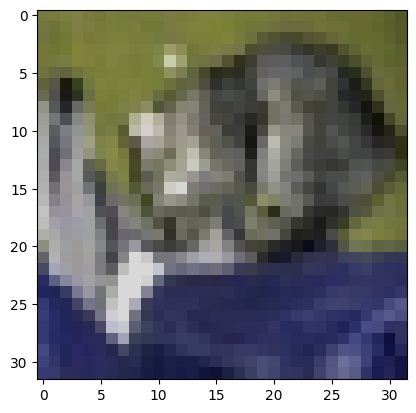

In [ ]:
# 4. Color Jitter
print("Color Jitter:")
transform_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_jitter, "Color Jitter")

Random Grayscale:
Files already downloaded and verified
Visualization for: Random Grayscale

Labels : cat


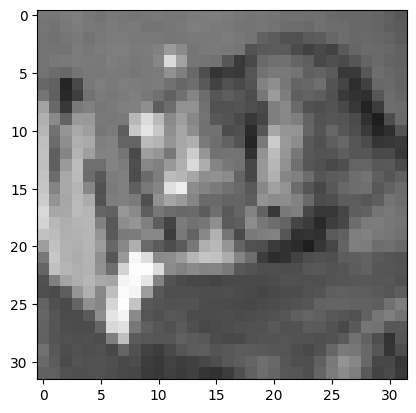

In [ ]:
# 5. Random Grayscale
print("Random Grayscale:")
transform_grayscale = transforms.Compose([
    transforms.RandomGrayscale(p=1.0),  # 100% 확률로 흑백 변환
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
visualize_augmentations(transform_grayscale, "Random Grayscale")

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None  # 가중치 초기화

    def train(self, X, y, learning_rate=1e-3, num_iters=100):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)

        loss_history = []
        for it in range(num_iters):
            loss, grad = self.loss(X, y)
            loss_history.append(loss)

            # Gradient Descent를 통한 가중치 업데이트
            self.W -= learning_rate * grad

        return loss_history

    def predict(self, X):
        return np.argmax(np.dot(X, self.W), axis=1)

    def loss(self, X_batch, y_batch):
        scores = np.dot(X_batch, self.W)
        num_train = X_batch.shape[0]

        # Cross-Entropy Loss 구현
        correct_class_scores = scores[np.arange(num_train), y_batch]
        margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)
        margins[np.arange(num_train), y_batch] = 0
        loss = np.sum(margins) / num_train
        grad = np.dot(X_batch.T, margins) / num_train

        return loss, grad

In [ ]:
# 원본 이미지 변환 (정규화만 적용)
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 좌우 반전
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 무작위 자르기
transform_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 무작위 회전
transform_rotate = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Color Jitter
transform_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def load_data(transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=True)

    X_train, y_train = next(iter(trainloader))
    X_train = X_train.view(X_train.size(0), -1).numpy()  # 1차원으로 변환
    y_train = y_train.numpy()

    return X_train, y_train

def prepare_data(transform):
    X, y = load_data(transform)

    # 학습 데이터와 검증 데이터를 80:20 비율로 나눔
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 편향(bias)을 위한 추가 열 삽입
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

    return X_train, X_val, y_train, y_val

In [ ]:
def train_and_evaluate(transform, num_iters=200):
    # 데이터 준비
    X_train, X_val, y_train, y_val = prepare_data(transform)

    # 모델 학습
    classifier = LinearClassifier()
    classifier.train(X_train, y_train, learning_rate=1e-3, num_iters=num_iters)

    # 검증 데이터에서 예측
    y_val_pred = classifier.predict(X_val)

    # 정확도 계산
    accuracy = np.mean(y_val == y_val_pred)
    return accuracy

In [ ]:
# 여러 Data Augmentation 기법들에 대한 성능 평가
transformations = {
    'Original': transform_original,
    'Random Horizontal Flip': transform_flip,
    'Random Crop': transform_crop,
    'Random Rotation': transform_rotate,
    'Color Jitter': transform_jitter
}

# 각 변환에 대한 정확도 저장
accuracies = {}

for name, transform in transformations.items():
    print(f'Training with {name} augmentation...')
    accuracy = train_and_evaluate(transform)
    accuracies[name] = accuracy
    print(f'Accuracy with {name}: {accuracy:.4f}')

Training with Original augmentation...
Files already downloaded and verified
Accuracy with Original: 0.3651
Training with Random Horizontal Flip augmentation...
Files already downloaded and verified
Accuracy with Random Horizontal Flip: 0.3714
Training with Random Crop augmentation...
Files already downloaded and verified
Accuracy with Random Crop: 0.3122
Training with Random Rotation augmentation...
Files already downloaded and verified
Accuracy with Random Rotation: 0.3411
Training with Color Jitter augmentation...
Files already downloaded and verified
Accuracy with Color Jitter: 0.3516


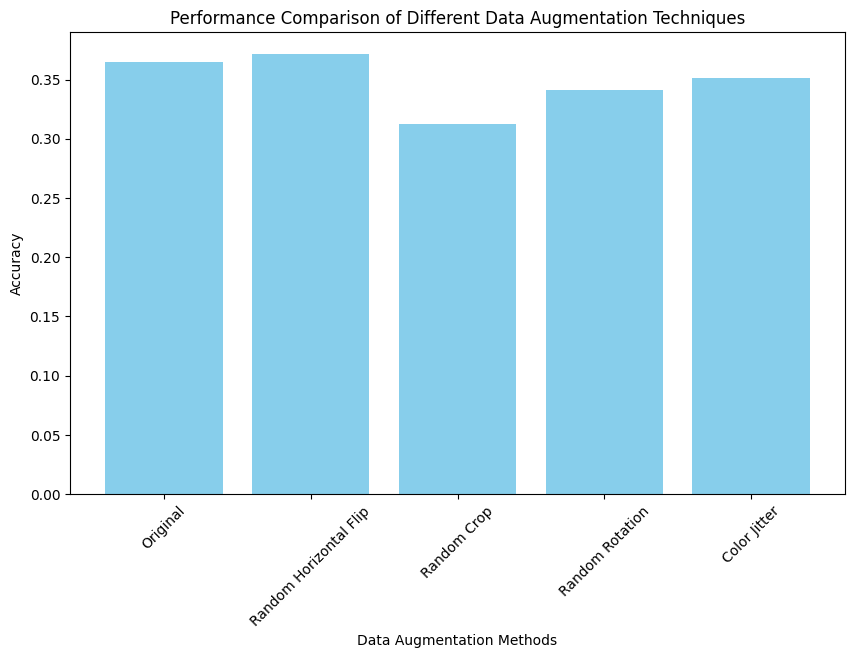

In [ ]:
# 성능 비교 그래프 시각화
def plot_accuracies(accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
    plt.xlabel('Data Augmentation Methods')
    plt.ylabel('Accuracy')
    plt.title('Performance Comparison of Different Data Augmentation Techniques')
    plt.xticks(rotation=45)
    plt.show()

# 성능 시각화
plot_accuracies(accuracies)

## Softmax

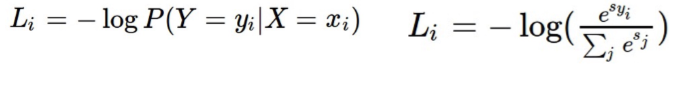

In [ ]:
def softmax_loss_vectorized(W, X, y):
  # 손실과 기울기 초기화
  N = X.shape[0]
  ##############
  #### code ####
  ##############

  # 순전파 (forward)
  ##############
  #### code ####
  ##############

  # 역전파 (backward)
  dout = np.copy(out)
  dout[np.arange(N), y] -= 1  # 실제 정답 클래스에 해당하는 위치에서 1을 빼줌 (크로스 엔트로피 손실의 기울기)
  dW = np.dot(X.T, dout)
  dW /= N  # 데이터 샘플 수로 평균 기울기 계산

  return loss, dW

In [ ]:

# Softmax 분류기
class Softmax(LinearClassifier):
    """ 다중 클래스 SVM 손실 함수를 사용하는 클래스 """
    ##############
    #### code ####
    ##############


In [ ]:
# 학습 데이터에 대한 예측 정확도 계산
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

# 검증 데이터에 대한 예측 정확도 계산
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.169551
validation accuracy: 0.174000


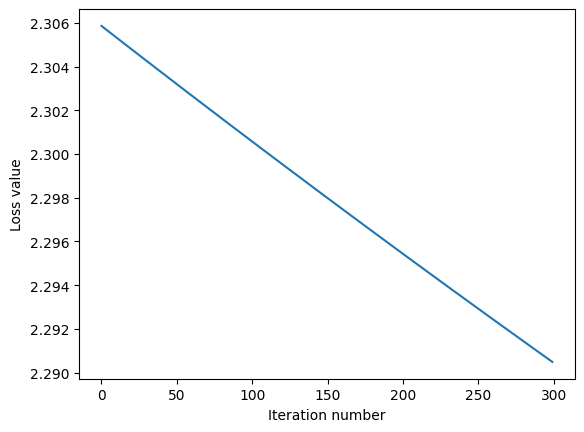

In [ ]:
# 손실 값 그래프 그리기
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()